In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.filter import resample, filter_data
from scipy.signal import find_peaks, detrend, periodogram, iirnotch, lfilter
from scipy.interpolate import splrep, splev
from scipy.integrate import trapz


data = pd.read_csv(r'C:\Users\Mahe\Desktop\HTIC Signal Processing Task\ECG 2.csv')

start = 400000

end = 450000

data = data[start:end]

sampling_freq = 400

#Normalize the data

data = (data - data.mean())/data.std()

data = data.astype(float)

print(data.shape)

(50000, 1)


<ipython-input-12-66fd0ec23d08>:3: RuntimeWarning: filter_length (2641) is longer than the signal (1), distortion is likely. Reduce filter length or filter a longer signal.
  data = filter_data(data, sampling_freq, 0.5, 40, verbose=0)


(50000,)
[  189   554   893  1253  1609  1950  2306  2677  3033  3357  3689  4037
  4369  4682  5013  5353  5685  6049  6425  6797  7142  7505  7858  8213
  8577  8938  9297  9649 10010 10377 10729 11080 11438 11786 12153 12525
 12882 13226 13573 13928 14274 14638 15018 15405 15778 16161 16545 16921
 17293 17677 18066 18438 18816 19189 19550 19918 20290 20650 20981 21338
 21705 22062 22422 22809 23198 23566 23949 24330 24701 25025 25353 25686
 26014 26326 26661 27022 27374 27745 28129 28502 28889 29274 29633 29978
 30317 30629 30910 31201 31517 31866 32209 32582 32962 33326 33689 34045
 34382 34693 35026 35370 35710 36037 36378 36729 37049 37353 37689 38037
 38385 38726 39066 39405 39713 40041 40381 40705 41006 41314 41638 41949
 42262 42593 42930 43242 43561 43877 44193 44489 44817 45165 45518 45861
 46217 46557 46870 47166 47482 47822 48170 48518 48869 49210 49517 49822]


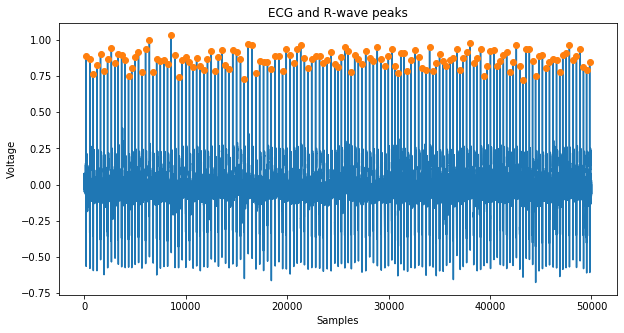

In [12]:
#Filter data to remove non-respiratory frequencies

data = filter_data(data, sampling_freq, 0.5, 40, verbose=0)

#Notch filter to remove baseline wander

Fnotch = 0.67 #Notch Frequency

BW = 5 #Bandwidth

Apass = 1 #Bandwidth Attenution

b, a = iirnotch(Fnotch/ (sampling_freq/2), BW/(sampling_freq/2), Apass)

data = lfilter(b, a, data)

data = np.squeeze(data)

print(data.shape)

#Find R-wave peaks

rr = find_peaks(data, distance= 40, height = 0.40)

print(rr[0])

peak_heights = rr[1]

rr = rr[0]

plt.figure(figsize = (10,5))

plt.plot(data)

plt.plot(rr, data[rr], 'o')

plt.title('ECG and R-wave peaks')

plt.xlabel('Samples')

_ = plt.ylabel('Voltage')

Text(0.5, 1.0, 'ECG Derived Respiration')

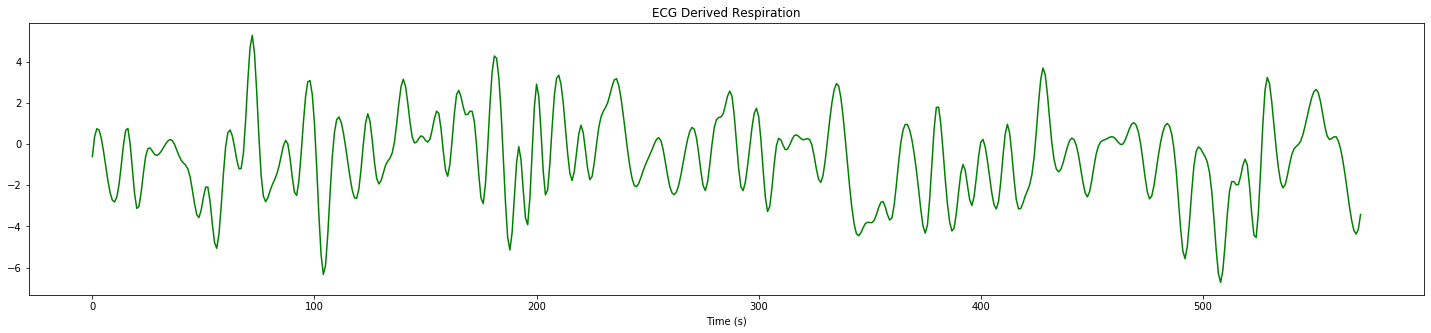

In [15]:
edr_values = []

for i in rr:
     
    #Area under the QRS complex is calculated within a 100ms window about the R peak
    
    edr_values.append(trapz(data[i - 40 : i + 40]))

edr_values = np.array(edr_values)

edr_values = edr_values.astype(float)

#Cubic spline interpolation of EDR

up_freq = 4

time_edr = np.arange(0, len(edr_values))
    
time_edr_interp = np.arange(0, time_edr[-1], 1/float(up_freq))
    
tck = splrep(time_edr, edr_values, k = 3)
    
edr_interp = splev(time_edr_interp, tck, der = 0)

plt.figure(figsize = (25,5))

plt.plot(edr_interp, 'g')

plt.xlabel('Time (s)')

plt.title('ECG Derived Respiration')


Maximum frequency, i.e. approx respiratory frequency: 0.28 Hz
Breathing Rate: 16.78 Breaths per minute


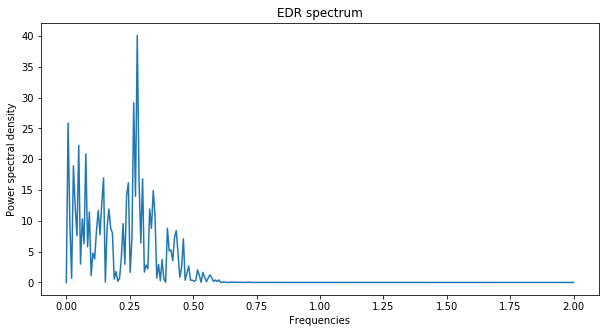

In [16]:
#Respiratory frequency using PSD of EDR

freqs, psd = periodogram(edr_interp, up_freq)

plt.figure(figsize = (10,5))

plt.plot(freqs, psd)

plt.ylabel('Power spectral density')

plt.xlabel('Frequencies')

plt.title('EDR spectrum')

b_freq = freqs[np.argmax(psd)]

print('Maximum frequency, i.e. approx respiratory frequency: %.2f Hz' % b_freq)

print('Breathing Rate: %.2f Breaths per minute' % (60*b_freq))
